In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping

%matplotlib inline

In [2]:
def create_replicas(x_data, x_err, n_rep = 100):
    x_dist = np.zeros((n_rep, x_data.shape[0]))
    for i, mean in enumerate(x_data):
        x_dist[:,i] = np.random.normal(loc=mean, scale=x_err[i], size=n_rep)
    return x_dist

In [3]:
def split_trval(x_data, y_data, perc = 0.3):
    size_val = round(len(x_data)*perc)
    idx = np.random.choice(np.arange(1, len(x_data)-1, 2), size_val, replace=False)
    x_val = x_data[idx]
    y_val = y_data[idx]
    x_tr = np.delete(x_data, idx)
    y_tr = np.delete(y_data, idx)

    return x_tr, y_tr, x_val, y_val

In [4]:
# Create the NN model
model = Sequential()
model.add(Dense(units = 1, activation = 'linear', input_shape=[1]))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam", metrics=["accuracy"])

# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# Display the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,155
Trainable params: 1,155
Non-trainable params: 0
_________________________________________________________________


2022-04-22 10:01:19.103181: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-22 10:01:19.103502: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Load data
filename = "./data/DATA_CHORUS_0.02.yaml"
with open(filename, "r") as file:
    input_data = yaml.safe_load(file)
x = input_data["x"]
Q2 = np.array(input_data["Q2"])
F_2 = np.array(input_data["F_2"])
F_2_err_stat = np.array(input_data["F_2_err_stat"])
F_2_err_sys = np.array(input_data["F_2_err_sys"])
F_2_err = F_2_err_stat + F_2_err_stat

2022-04-22 10:01:22.108873: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-22 10:01:22.128296: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


Epoch 00549: early stopping
Epoch 00055: early stopping
Epoch 00668: early stopping
Epoch 00052: early stopping
Epoch 00069: early stopping
Epoch 00093: early stopping
Epoch 00112: early stopping
Epoch 00759: early stopping
Epoch 00051: early stopping
Epoch 00065: early stopping


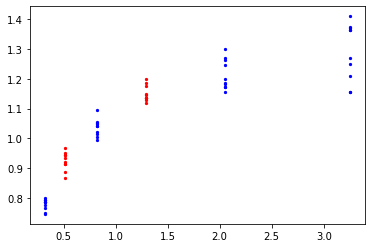

In [6]:
# Loop over replicas
n_rep = 10
F_2_reps = create_replicas(F_2, F_2_err, n_rep = n_rep)
x_pred = np.linspace(Q2[0], Q2[-1], num=100)
y_pred = []

for y_data in F_2_reps:
    x_tr, y_tr, x_val, y_val = split_trval(Q2, y_data)
    plt.scatter(x_tr, y_tr, s=5, color = "blue")
    plt.scatter(x_val, y_val, s=5, color = "red")
    model.fit(x_tr, y_tr, validation_data=(x_val ,y_val), epochs=1000, batch_size=10, verbose=0, callbacks=[es])
    
    y_pred.append(model.predict(x_pred))

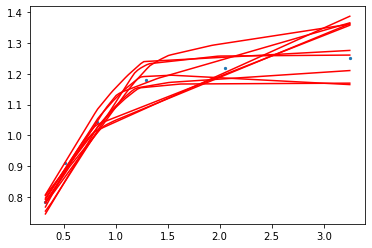

In [7]:
plt.scatter(Q2, F_2, s=5, label = "Data")
for y in y_pred:
    plt.plot(x_pred, y, color="red")

In [18]:
p1_high = np.nanpercentile(y_pred,84,axis=0)
p1_low = np.nanpercentile(y_pred,16,axis=0)
p1_mid = (p1_high + p1_low )/2.
p1_error = (p1_high - p1_low )/2.

p1_mid = p1_mid.reshape(-1)
p1_error = p1_error.reshape(-1)

Text(0.5, 1.0, 'Prediction of $F_2$ at $x=0.02$')

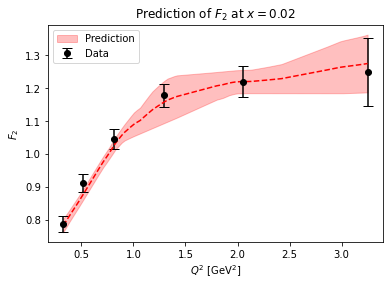

In [61]:
plt.errorbar(Q2, F_2, yerr=F_2_err, label = "Data", fmt="ko", capsize=5)
plt.fill_between(x_pred, y1=p1_mid-p1_error, y2=p1_mid+p1_error, color="red", edgecolor="red", label="Prediction", alpha=0.25)
plt.plot(x_pred, p1_mid, color="red", linestyle="dashed")
plt.legend()
plt.xlabel("$Q^2$ [GeV$^2$]")
plt.ylabel("$F_2$")
plt.title(f"Prediction of $F_2$ at $x={x}$")